# Introduction

---



This project is an exploration of the use of **AutoML tools** to solve **time series forecasting** problems.

**Forecasting**, or predicting the future value of a variable based on time series data, benefits many real-world business sectors. Its implementation can easily be found in various areas around us, such as weather prediction, stock market forecasting, and sales prediction. However, time series modeling is complex and differs from other machine learning problems, such as classification or regression.

**AutoML** stands for automatic machine learning (ML). Generally, these tools automate tasks such as model selection and hyperparameter tuning, making these processes significantly less tedious. There are drawbacks to using AutoML, such as limited flexibility in tweaking the models. However, it is an excellent tool for prototyping and validating that the dataset is not just noise.

This project is focusing on these AutoML tools for time-series forecasting:
- [AutoTS](https://winedarksea.github.io/AutoTS/build/html/source/tutorial.html), focusing on classical and traditional machine learning methods,
- [GCP AutoML](https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting/overview), cloud-based solutions.

For each AutoML tools, we can evaluate their performance, ease of use, interpretability, and robustness.

**Keywords:** time series, forecasting, AutoML

## Dataset

This project uses a **daily commodity price dataset** from several cities in East Java, covering the time period from January 2018 to July 2024.

The chosen commodity is **shallot**, as it is a staple ingredient and the prices can fluctuate to more than triple the average.

This project will focus on **two regions: Mojokerto and Surabaya**. These regions represent smaller city (Mojokerto) and a major consumer market (Surabaya), respectively.

The data is obtained from [SISKAPERBAPO Jatim](https://siskaperbapo.jatimprov.go.id/) website.

# EDA
---



In [18]:
from google.cloud import storage

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import time
import os
import io

In [19]:
def download_csv_from_gcs(bucket, file_name,
                          date_columns=None, col_names=None):
    """ A function to download dataset from GCS. """

    blob = bucket.blob(file_name)
    data = blob.download_as_text()
    df = pd.read_csv(io.StringIO(data),
                     parse_dates=date_columns,
                     usecols=col_names)
    return df

In [21]:
# Create a client GCS and get the specified bucket
client = storage.Client()
bucket = client.get_bucket(BUCKET_NAME)

In [22]:
prices_df = download_csv_from_gcs(bucket, PRICES_CSV, date_columns=["date"])

In [23]:
# We can take a look at the shallot price dataset, which has a daily frequency
prices_df.groupby(["data_split", "regions"]).head(2)

,date,data_split,regions,price
0,2018-01-01,TRAIN,mojokerto,14750
1,2018-01-02,TRAIN,mojokerto,14750
2374,2024-07-02,VALIDATE,mojokerto,26500
2375,2024-07-03,VALIDATE,mojokerto,24250
2389,2024-07-17,TEST,mojokerto,22412
2390,2024-07-18,TEST,mojokerto,22412
2404,2018-01-01,TRAIN,surabaya,20000
2405,2018-01-02,TRAIN,surabaya,19800
4778,2024-07-02,VALIDATE,surabaya,29666
4779,2024-07-03,VALIDATE,surabaya,29333


We can check the dataset's timestamps. The `TRAIN` set contains approximately four years and 6 months of data, while both the `TEST` and `VALIDATE` sets include three months of data each.

In [27]:
# check the min/max date of each sets
prices_df.groupby(["data_split", "regions"])["date"].agg(["min", "max"])

min        max
data_split regions                        
TEST       mojokerto 2024-07-17 2024-07-31
           surabaya  2024-07-17 2024-07-31
TRAIN      mojokerto 2018-01-01 2024-07-01
           surabaya  2018-01-01 2024-07-01
VALIDATE   mojokerto 2024-07-02 2024-07-16
           surabaya  2024-07-02 2024-07-16

In [29]:
# check the rows count of each sets
prices_df.groupby(["data_split", "regions"])["price"].count()

data_split  regions  
TEST        mojokerto      15
            surabaya       15
TRAIN       mojokerto    2374
            surabaya     2374
VALIDATE    mojokerto      15
            surabaya       15
Name: price, dtype: int64

In [32]:
train_start = prices_df[prices_df["data_split"] == "TRAIN"]["date"].min()
train_end = prices_df[prices_df["data_split"] == "TRAIN"]["date"].max()

val_start = prices_df[prices_df["data_split"] == "VALIDATE"]["date"].min()
val_end = prices_df[prices_df["data_split"] == "VALIDATE"]["date"].max()

test_start = prices_df[prices_df["data_split"] == "TEST"]["date"].min()
test_end = prices_df[prices_df["data_split"] == "TEST"]["date"].max()

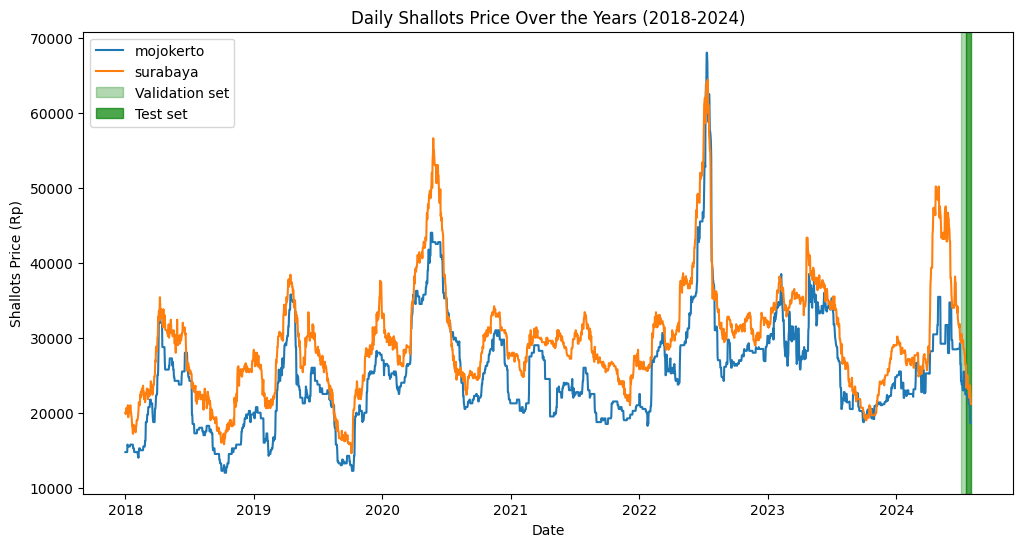

In [41]:
# Plot the daily shallot prices to see the fluctuation and data partition
# to train, val, and test

plt.figure(figsize=(12, 6))
sns.lineplot(prices_df, x="date", y="price", hue="regions")

# Mark the validation timestamp
plt.axvspan(pd.to_datetime(val_start), pd.to_datetime(val_end),
            color='green', alpha=0.3, label='Validation set')

# Mark the test timestamp
plt.axvspan(pd.to_datetime(test_start), pd.to_datetime(test_end),
            color='green', alpha=0.7, label='Test set')

plt.xlabel("Date")
plt.ylabel("Shallots Price (Rp)")
plt.title("Daily Shallots Price Over the Years (2018-2024)")
plt.legend()
plt.show()

From the plot above, we can observe that the price trend tends to peak at the beginning of the year and declines in the second half. However, we notice that the seasonal pattern is not very strong in our dataset, especially in the year 2021.

We can see the price distribution for each month throughout the year in the plot below.

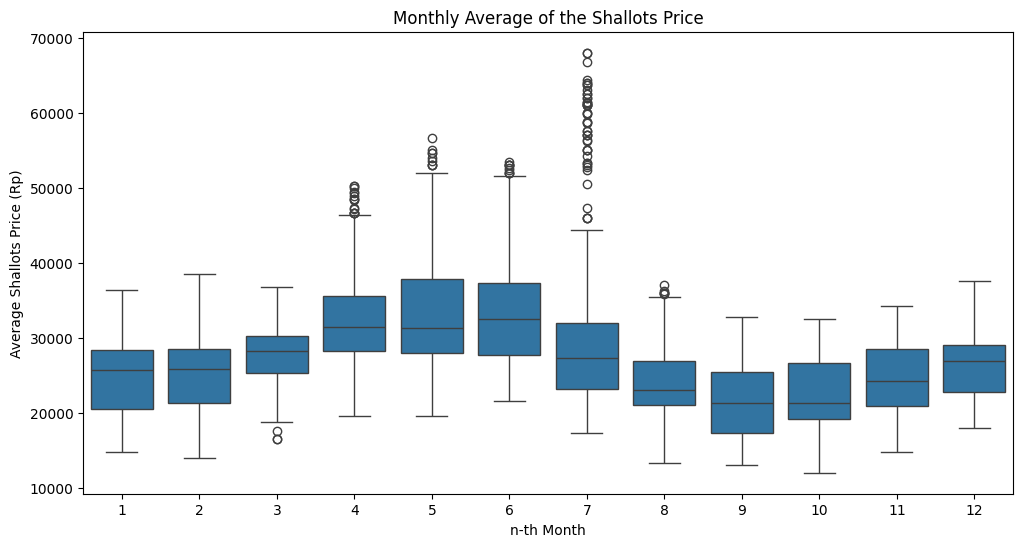

In [42]:
plt.figure(figsize=(12, 6))

sns.boxplot(prices_df, x=prices_df["date"].dt.month, y="price")

plt.xlabel("n-th Month")
plt.ylabel("Average Shallots Price (Rp)")
plt.title("Monthly Average of the Shallots Price")
plt.show()

Then, we can examine the statistics of shallot prices.

In [44]:
prices_df[["regions", "price"]].groupby(["regions"]).agg(
    ["median", "mean", "std", "min", "max"]
)

price                                         
            median          mean          std    min    max
regions                                                    
mojokerto  24250.0  25136.561980  7089.663609  12000  68000
surabaya   29000.0  29622.760399  7465.056849  14600  64400

And, we can also check the prices histogram.

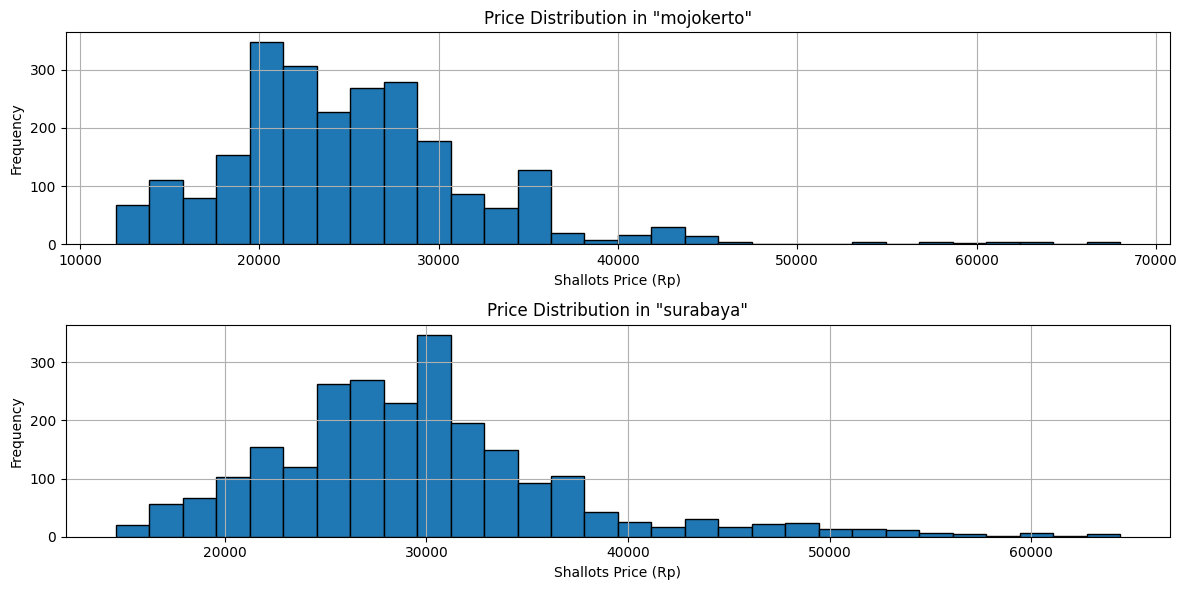

In [46]:
regions = prices_df['regions'].unique()

fig, ax = plt.subplots(len(regions), 1, figsize=(12, 6))
for i, region in enumerate(regions):
    prices_df[prices_df['regions'] == region]['price'].hist(bins=30,
                                                            edgecolor='black',
                                                            ax=ax[i])

    ax[i].set_title(f'Price Distribution in "{region}"')
    ax[i].set_xlabel('Shallots Price (Rp)')
    ax[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

As we can observe from the plots and data statistics, the daily shallot prices fluctuate significantly over time.

# Feature Engineering

Now that we have observed price fluctuations, we need to collect additional features to help our model accurately predict future shallot prices in the market.

These additional features include:
- weather data,
- time-related data, and
- holidays.

## Weather data

A feature set that could improve the shallot price forecasting model is weather data.

Shallot farming is typically done during the **dry season**, making weather parameters such as average precipitation, daylight duration, and temperature potentially useful in forecasting prices.

However, for simplicity in this project, it is crucial to ensure that these weather parameters are **available during the prediction phase**. Therefore, this project will use the **one-month average of the previous year's weather data** as a feature. This is based on the assumption that last year's weather conditions will be similar to those of the current year.

The weather data is obtained from the free and open-sourced weather API [Open-Meteo](https://open-meteo.com/). We retrieve daily weather data by targeting the locations of several cities across East Java and aggregating the results by calculating the mean value.

In [55]:
# Retrieve the weather data which includes precipitation, daylight duration, and temperature
weather_df = download_csv_from_gcs(bucket, WEATHER_CSV, ["date"])
weather_df.set_index("date", inplace=True)

weather_columns = ["featw_temperature_c", "featw_dayligh_duration_h",
                   "featw_precipitation_sum_mm"]
weather_df.columns = weather_columns

In [56]:
weather_df.head()

,featw_temperature_c,featw_dayligh_duration_h,featw_precipitation_sum_mm
date,,,
2016-01-01,26.84,45205.0,6.58
2016-01-02,26.71,45198.0,5.81
2016-01-03,26.58,45191.0,9.48
2016-01-04,26.29,45183.0,7.10
2016-01-05,26.65,45175.0,2.52


In [58]:
weather_df['month'] = weather_df.index.month
weather_df['year'] = weather_df.index.year
monthly_avg_weather = weather_df.groupby(["year", "month"]).mean().round(2)
monthly_avg_weather = monthly_avg_weather.reset_index()

In [59]:
monthly_avg_weather.head()

,year,month,featw_temperature_c,featw_dayligh_duration_h,featw_precipitation_sum_mm
0,2016,1,26.68,45029.48,7.85
1,2016,2,25.97,44449.52,17.58
2,2016,3,26.75,43705.45,9.03
3,2016,4,26.71,42960.70,7.18
4,2016,5,26.97,42360.16,4.27


In [60]:
# Helper function

def get_last_year_weather(row, weather_data):
    """ A function to return the last year month-averaged weather data. """

    month = row["date"].month
    last_year = row["date"].year - 1

    weather_last_year = weather_data[(weather_data["year"] == last_year) &
                                     (weather_data["month"] == month)]

    return weather_last_year.iloc[0]

In [61]:
feat_df = prices_df.copy()

In [62]:
for col in weather_columns:
    feat_df[col] = feat_df.apply(
                      lambda row: get_last_year_weather(row, monthly_avg_weather)[col],
                      axis=1
                    )

In [65]:
feat_df.groupby(["regions", "data_split"]).head(1)

,date,data_split,regions,price,featw_temperature_c,featw_dayligh_duration_h,featw_precipitation_sum_mm
0,2018-01-01,TRAIN,mojokerto,14750,25.78,45018.90,13.32
2374,2024-07-02,VALIDATE,mojokerto,26500,25.87,42207.84,1.75
2389,2024-07-17,TEST,mojokerto,22412,25.87,42207.84,1.75
2404,2018-01-01,TRAIN,surabaya,20000,25.78,45018.90,13.32
4778,2024-07-02,VALIDATE,surabaya,29666,25.87,42207.84,1.75
4793,2024-07-17,TEST,surabaya,26333,25.87,42207.84,1.75


## Time-related Features

Next, we can add time-related features to capture **seasonality** in our dataset.

Tools like GCP AutoML support the automatic inclusion of date features, while AutoTS requires date features to be added manually. Therefore, we will add multiple time-related features to our dataset.

However, instead of adding straight-forward time features such as day, month, and year, we can encode these features using **sine and cosine transformations**. This approach is commonly used in time series forecasting, as these transformations provide a **continuous representation** of cyclical time patterns.

For a given $x$ time feature that has a $T$ period:

$$ \text{sin_x} = \sin \left( \frac{2 \pi x}{T} \right), $$
$$ \text{cos_x} = \cos \left( \frac{2 \pi x}{T} \right), $$

which in our case, $T$ is equal to 365.

In [71]:
# Add day of year as a time feature
feat_df["day_of_year"] = feat_df["date"].dt.dayofyear

# Apply sine and cosine transformations with period 365
T = 365
feat_df["day_of_year_sin"] = np.sin(2 * np.pi * feat_df["day_of_year"] / T)
feat_df["day_of_year_cos"] = np.cos(2 * np.pi * feat_df["day_of_year"] / T)

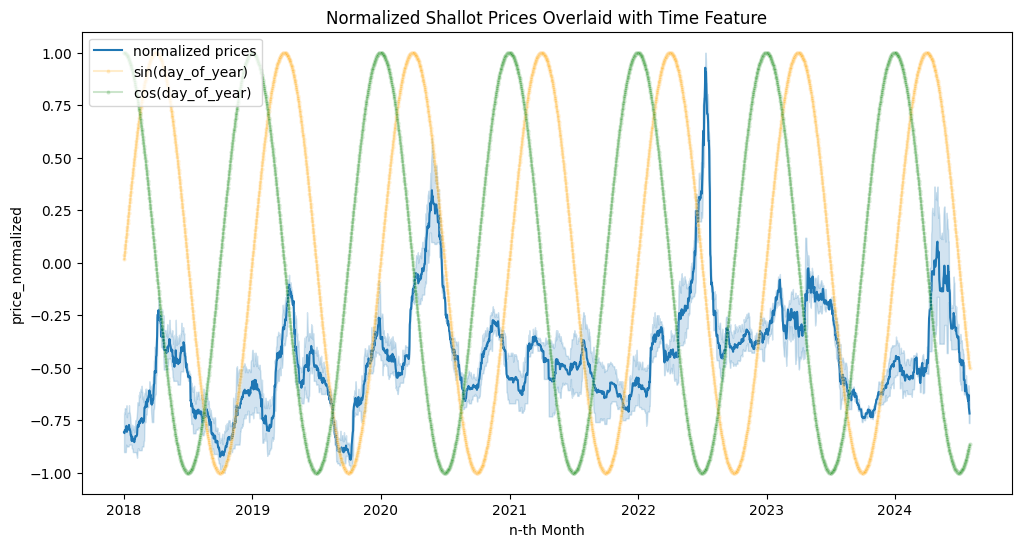

In [82]:
# Plot the time features with the normalized prices
plt.figure(figsize=(12, 6))

# Normalize the prices to (-1, 1) to match the value range
min, max = feat_df["price"].min(), feat_df["price"].max()
feat_df["price_normalized"] = 2*(feat_df["price"] - min)/(max - min) - 1

# Plot the prices
sns.lineplot(feat_df, x="date", y="price_normalized", label="normalized prices")

# Plot the time feature
sns.lineplot(feat_df, x="date", y="day_of_year_sin",
             alpha=0.2, marker='.', color="orange", label="sin(day_of_year)")
sns.lineplot(feat_df, x="date", y="day_of_year_cos",
             alpha=0.2, marker='.', color="green", label="cos(day_of_year)")

plt.xlabel("n-th Month")
plt.title("Normalized Shallot Prices Overlaid with Time Feature")
plt.legend(loc="upper left")
plt.show()

We can see from the plot above that our time feature is encoded as intended.

## Holiday

There one more factor that we think can cause fluctuations in commodity prices, which is holidays.

The demand for certain commodities can spike during holiday periods, leading to an increase in prices. For instance, around occasions like Eid al-Fitr, Eid al-Adha, Christmas, and New Year, we often observe a rise in commodity prices.

We try to see this holidays phenomenon in this dataset, using Python library [holidays](https://pypi.org/project/holidays/).

In [81]:
import holidays

id_holidays = holidays.ID()
feat_df["is_holidays"] = feat_df["date"].apply(lambda x: 1 if id_holidays.get(x) else 0)
avg_price = feat_df.groupby('is_holidays')['price'].mean().reset_index()

Next, we want to see if the price difference during holidays is significant enough to justify adding the holiday feature as an input.

We test this using a statistical test, the T-test, which is a statistical test for comparing means between two groups.

In [83]:
from scipy import stats

# Get the prices
holiday_prices = feat_df[feat_df['is_holidays'] == 1]['price']
non_holiday_prices = feat_df[feat_df['is_holidays'] == 0]['price']

# T-test
t_stat, p_value = stats.ttest_ind(holiday_prices, non_holiday_prices)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 4.61709212165724, P-value: 3.9930329242275776e-06


Given the above results, we can conclude that:
- There is a substantial difference between the two groups being compared.
- The significance of the P-value indicates that this finding is unlikely to be due to random chance.

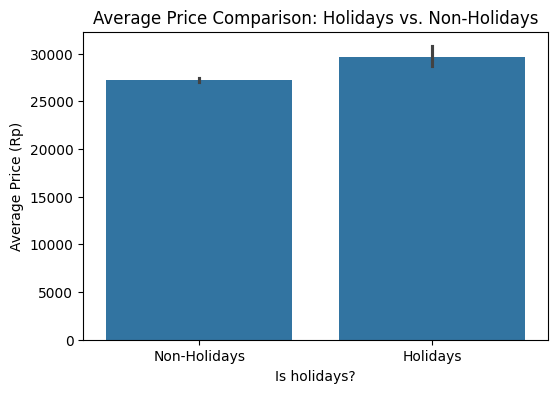

In [84]:
# Plot the price difference
plt.figure(figsize=(6, 4))

sns.barplot(data=feat_df, x='is_holidays', y='price')

plt.xticks(ticks=[0, 1], labels=['Non-Holidays', 'Holidays'])
plt.xlabel('Is holidays?')
plt.ylabel('Average Price (Rp)')
plt.title('Average Price Comparison: Holidays vs. Non-Holidays')
plt.show()

Therefore, we add a one-hot encoded holiday feature to our dataset.

In [85]:
holidays_df = feat_df["date"].apply(lambda x: fix_holidays(id_holidays.get(x)))
holidays_dummies = pd.get_dummies(holidays_df,
                                  prefix="feath",
                                  drop_first=True,
                                  dtype=int)

NameError: name 'fix_holidays' is not defined

In [ ]:
df_feat = pd.concat([df_feat, holidays_dummies], axis=1)